# CrowdMRI (aka MRIQC Web API)



<img src="crowdmri-flowchart.png" />

## Querying the database

- Manually (online): https://mriqc.nimh.nih.gov
- Python

In [13]:
import os
import sys
import numpy as np
import pandas as pd
from json import load
import urllib.request, json 
from pandas.io.json import json_normalize

import datetime
from dateutil import parser
import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

In [ ]:
def get_iqms(modality, versions=None, software='mriqc', out_file=None, page_size=25):
    """
    Grab all iqms for the given modality and the list of versions
    """
    

    
    url_root = 'https://mriqc.nimh.nih.gov/api/v1/{modality}?{query}'
    page = 1
    
    if out_file is None:
        out_file = 'webapi-%s.csv' % modality
    
    database = pd.DataFrame()
    if os.path.isfile(out_file):
        database = pd.read_csv(out_file)
        page = len(database) // page_size + 1
        print('Found old records. Starting on page ', page)

    if versions is None:
        versions = ['*']

    for version in versions:
        while True:
            query = 'max_results=%d&page=%d' % (page_size, page)
            
            filters = []
            if software is not None:
                filters.append('"provenance.software":"%s"' % software)
            
            if version != '*':
                filters.append('"provenance.version":"%s"' % version)
            
            if filters:
                query += '&where={%s}' % ','.join(filters)
                
            page_url = url_root.format(
                modality=modality,
                query=query
            )
            with urllib.request.urlopen(page_url) as url:
                data = json.loads(url.read().decode())
                database = database.append(
                    json_normalize(data['_items']), sort=False)
                
                database.to_csv(out_file)
                sys.stdout.write('.')
                sys.stdout.flush()
                if 'next' not in data['_links'].keys():
                    break
                else:
                    page += 1

    database.to_csv(out_file)
    return database

In [ ]:
df_t1w = get_iqms('T1w', software=None, out_file=os.path.expanduser('~/data/nipreps/.crowdmri-T1w.csv'), page_size=1000)

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (91,96,104,106,108,110,111,118,119,120,123,124,125,126,127,128,130) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


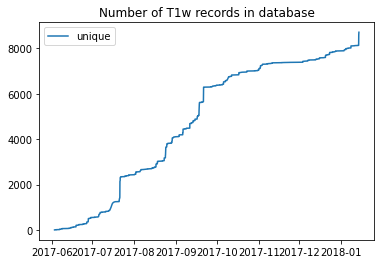

In [4]:
df_t1w = pd.read_csv(os.path.expanduser('~/data/nipreps/.crowdmri-T1w.csv'))
df_t1w_unique = df_t1w.drop_duplicates(subset=['provenance.md5sum'])
dates_t1w_u = [parser.parse(d) for d in df_t1w_unique['_created'].values]
dates_t1w_u.sort()

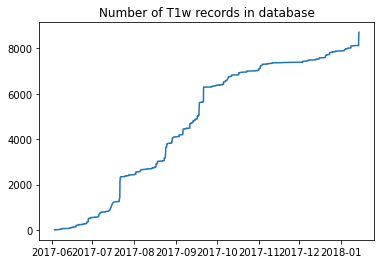

In [7]:
ax = plt.subplot(111)
ax.plot(dates_t1w_u, list(range(1, len(dates_t1w_u) + 1)), label='unique')
ax.set_title('Number of T1w records in database');

In [11]:
def plot_measure(data, xlabel=None, label=None, ax=None, min=None, max=None):
    """
    Distribution plot of a given measure
    """
    sns.distplot(data, ax=ax, label=label)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    
    if min is None:
        min = np.percentile(data, 0.5)
    
    if max is None:
        max = np.percentile(data, 99.5)
    ax.set_xlim((min, max))

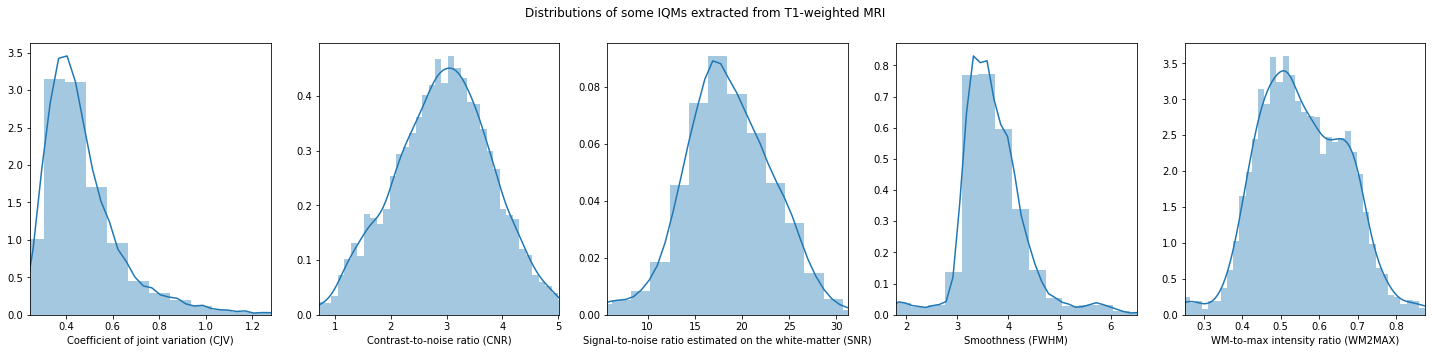

In [15]:
f, ax = plt.subplots(1, 5, figsize=(25,5))
plot_measure(df_t1w_unique.cjv, xlabel='Coefficient of joint variation (CJV)', ax=ax[0])
plot_measure(df_t1w_unique.cnr, xlabel='Contrast-to-noise ratio (CNR)', ax=ax[1])
plot_measure(df_t1w_unique.snr_wm, xlabel='Signal-to-noise ratio estimated on the white-matter (SNR)', ax=ax[2])
plot_measure(df_t1w_unique.fwhm_avg, xlabel='Smoothness (FWHM)', ax=ax[3])
plot_measure(df_t1w_unique.wm2max, xlabel='WM-to-max intensity ratio (WM2MAX)', ax=ax[4])
plt.suptitle('Distributions of some IQMs extracted from T1-weighted MRI');